Notebook investigating different encodings for discrete numerical features. The main idea is to treat them as categorical features initially, then we can experiment with different encodings and grouping rare labels, if appropriate. I'll also perform a rotation via PCA to find the optimum coordinate system for the latitude and longitude. 

In [1]:
import sys
sys.path.append('../')

import src.utils.eda as eda
import src.utils.helper as helper
import src.train as train

from feature_engine import encoding as ce

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output = "pandas")

from sklego.preprocessing import RepeatingBasisFunction

In [2]:
data, discrete, temporal, continuous, categorical = helper.load_base_data()
data.head()

Discrete: ['Latitude', 'Longitude', 'Altitude']
Temporal: ['month', 'hour']
Continuous: ['Humidity', 'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling']
Categorical: ['Location', 'Season']


,Location,Latitude,Longitude,Altitude,Season,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling,PolyPwr,month,hour
0,Camp Murray,47.11,-122.57,25.480965,Winter,81.71997,12.86919,8.053964,16.096495,1010.6,22.028990,2.42769,12,11
1,Camp Murray,47.11,-122.57,25.480965,Winter,96.64917,9.66415,0.000000,16.096495,1011.3,0.701755,2.46273,12,13
2,Camp Murray,47.11,-122.57,25.480965,Winter,93.61572,15.44983,8.053964,16.096495,1011.6,0.976354,4.46836,12,13
3,Camp Murray,47.11,-122.57,25.480965,Winter,77.21558,10.36659,8.053964,3.219299,1024.4,0.183066,1.65364,12,12
4,Camp Murray,47.11,-122.57,25.480965,Winter,54.80347,16.85471,4.832378,4.828948,1023.7,0.274600,6.57939,12,14


In [3]:
X = data[discrete + temporal + continuous + categorical].copy()

y = data['PolyPwr'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    train_size=0.8,  # percentage of obs in train set
    random_state=0)  # seed to ensure reproducibility

scaler = StandardScaler()

X_train[['Latitude', 'Longitude']] = scaler.fit_transform(X_train[['Latitude', 'Longitude']])
X_test[['Latitude', 'Longitude']] = scaler.transform(X_test[['Latitude', 'Longitude']])

pca = PCA()
pca.fit(X_train[['Latitude', 'Longitude']])

X_train['geo_pca0'] = pca.transform(X_train[['Latitude', 'Longitude']])['pca0']
X_train['geo_pca1'] = pca.transform(X_train[['Latitude', 'Longitude']])['pca1']

X_test['geo_pca0'] = pca.transform(X_test[['Latitude', 'Longitude']])['pca0']
X_test['geo_pca1'] = pca.transform(X_test[['Latitude', 'Longitude']])['pca1']

X_train = X_train.drop(columns=['Latitude', 'Longitude'], axis=1)
X_test = X_test.drop(columns=['Latitude', 'Longitude'], axis=1)

print(X_train.shape, X_test.shape)
print(X_train.columns)

(16836, 13) (4209, 13)
Index(['Altitude', 'month', 'hour', 'Humidity', 'AmbientTemp', 'Wind.Speed',
       'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location', 'Season',
       'geo_pca0', 'geo_pca1'],
      dtype='object')


In [4]:
visibility_column_index = 19
cloud_ceiling_column_index = 21

pipeline = Pipeline([
    
    ('rare_label_encoder', 
     ce.RareLabelEncoder(tol=0.05,
                         n_categories=7,
                         variables=['Location'])),
    
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['Season'])),
    
    ('categorical_encoder_loc',
     ce.OrdinalEncoder(encoding_method='arbitrary',
                       variables=['Location'])),
    
    ('rbf_month',
     RepeatingBasisFunction(remainder="passthrough",
                            n_periods=12,
                            column="month",
                            width=1.0,
                            input_range=(1,12))),
    
    ('binarizer_vis', 
     ColumnTransformer(transformers=[('binarize_vis', 
                                      Binarizer(threshold=15), 
                                      [visibility_column_index, cloud_ceiling_column_index])], 
                       remainder='passthrough')),
    
    ('xgb', train.build_model())

])

scores = train.train_model(inputs=X_train, target=y_train, pipeline=pipeline)

CV Average R2: 0.659315466619023


No improvements were found with the transformed coordinates so we keep the original pipeline and features. 

### Categorical encodings
We'll now treat the discrete features as categorical and encode them ordinally and with mean encoding. Grouping the rare labels is also worth looking at.  

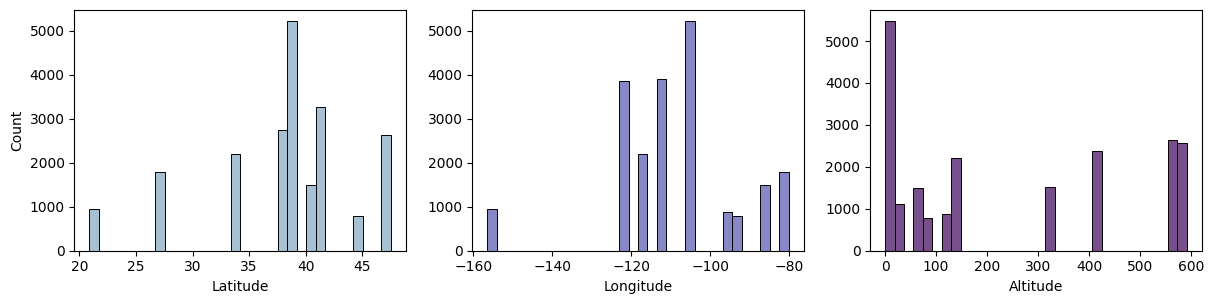

In [5]:
eda.numerical_distributions(df=data[discrete], features=discrete)

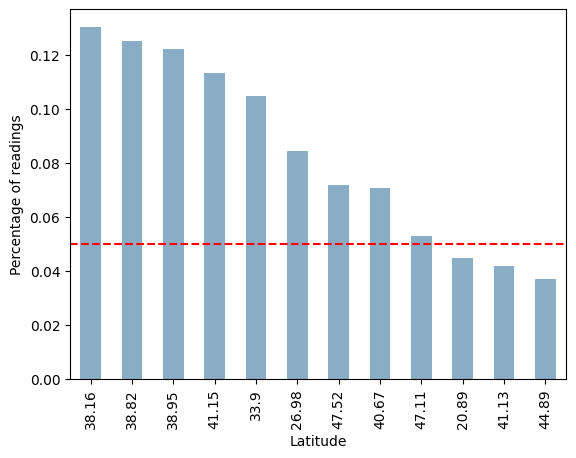

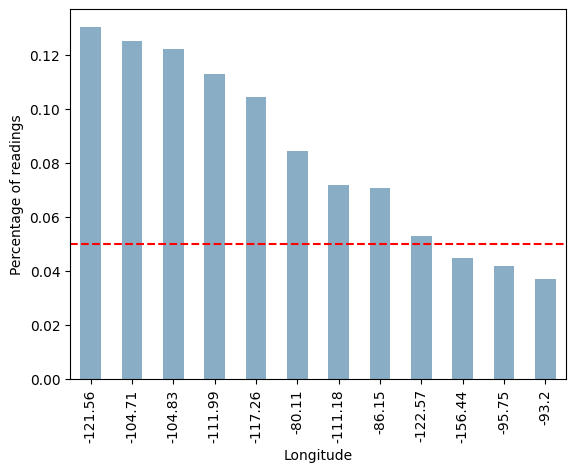

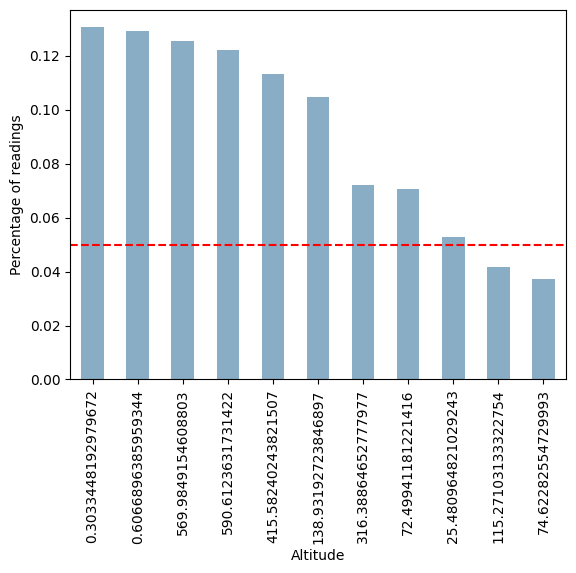

In [6]:
for col in discrete:
    eda.plot_percentages_by_label(data[discrete].astype('O'), col)

In [7]:
X = data[discrete + temporal + continuous + categorical].copy()
X['Altitude'] = X['Altitude'].astype('O')

y = data['PolyPwr'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    train_size=0.8,  # percentage of obs in train set
    random_state=0)  # seed to ensure reproducibility

print(X_train.shape, X_test.shape)
print(X_train.columns)

(16836, 13) (4209, 13)
Index(['Latitude', 'Longitude', 'Altitude', 'month', 'hour', 'Humidity',
       'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling',
       'Location', 'Season'],
      dtype='object')


In [8]:
visibility_column_index = 19
cloud_ceiling_column_index = 21

pipeline = Pipeline([
    
    ('rare_label_encoder', 
     ce.RareLabelEncoder(tol=0.05,
                         n_categories=7,
                         variables=['Location'])),
    
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['Season', 'Altitude'])),
    
    ('categorical_encoder_loc',
     ce.OrdinalEncoder(encoding_method='arbitrary',
                       variables=['Location'])),
    
    ('rbf_month',
     RepeatingBasisFunction(remainder="passthrough",
                            n_periods=12,
                            column="month",
                            width=1.0,
                            input_range=(1,12))),
    
    ('binarizer_vis', 
     ColumnTransformer(transformers=[('binarize_vis', 
                                      Binarizer(threshold=15), 
                                      [visibility_column_index, cloud_ceiling_column_index])], 
                       remainder='passthrough')),
    
    ('xgb', train.build_model())

])

scores = train.train_model(inputs=X_train, target=y_train, pipeline=pipeline)

CV Average R2: 0.6621472492278118


### Summary
Transforming the latitude and longitude with PCA had no impact, and neither did various categorical encodings for these features. Ordered encoding of the altitude gave a slight uptick in R2. The new R2 is ~0.6621 with the following pipeline. 

In [9]:
pipeline

Pipeline(steps=[('rare_label_encoder',
                 RareLabelEncoder(n_categories=7, variables=['Location'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Season', 'Altitude'])),
                ('categorical_encoder_loc',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Location'])),
                ('rbf_month',
                 RepeatingBasisFunction(column='month', input_range=(1, 12),
                                        remainder='passthr...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])